# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Data Curation Part 2

Today we'll extend our dataset to a greater coverage, and craft it into an excellent dataset for training.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

## Important Note - read me first please

We are about to craft a massive dataset of 400,000 items covering multiple types of product. In Week 7 we will be using this data to train our own model. It's a pretty big dataset, and depending on the GPU you select, training could take 20+ hours. It will be really good fun, but it could cost a few dollars in compute units.

As an alternative, if you want to keep things quick & low cost, you can work with a smaller dataset focused only on Home Appliances. You'll be able to cover the same learning points; the results will be good -- not quite as good as the full dataset, but still pretty amazing! If you'd prefer to do this, I've set up an alternative jupyter notebook in this folder called `lite.ipynb` that you should use in place of this one.

In [1]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
%matplotlib inline

## The ItemLoader code

Look in loaders.py - there's some useful code to make life easier for us

In [5]:
# Load in the same dataset as last time

items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [01:01<00:00,  1.54it/s]


Completed Appliances with 28,625 datapoints in 1.1 mins


In [ ]:
# Look for a familiar item..
print(items[10].prompt)

## Now to SCALE UP

Let's look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [7]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [10]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# Now, time for a coffee break!!
# By the way, I put the biggest datasets first.. it gets faster.

Loading dataset Automotive


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2004/2004 [30:15<00:00,  1.10it/s]


Completed Automotive with 911,688 datapoints in 30.8 mins
Loading dataset Electronics


meta_Electronics.jsonl:  26%|##5       | 1.36G/5.25G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/1610012 [00:00<?, ? examples/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1611/1611 [17:08<00:00,  1.57it/s]


Completed Electronics with 443,473 datapoints in 40.1 mins
Loading dataset Office_Products


meta_Office_Products.jsonl:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 711/711 [06:23<00:00,  1.85it/s]


Completed Office_Products with 240,394 datapoints in 55.5 mins
Loading dataset Tools_and_Home_Improvement


meta_Tools_and_Home_Improvement.jsonl:   0%|          | 0.00/4.85G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1474/1474 [17:33<00:00,  1.40it/s]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 41.2 mins
Loading dataset Cell_Phones_and_Accessories


meta_Cell_Phones_and_Accessories.jsonl:   0%|          | 0.00/4.02G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/1288490 [00:00<?, ? examples/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1289/1289 [13:58<00:00,  1.54it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 41.3 mins
Loading dataset Toys_and_Games


ConnectionError: (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 9f7fa61a-d576-4065-8189-391cdc4d6988)')

In [11]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,375,475 items


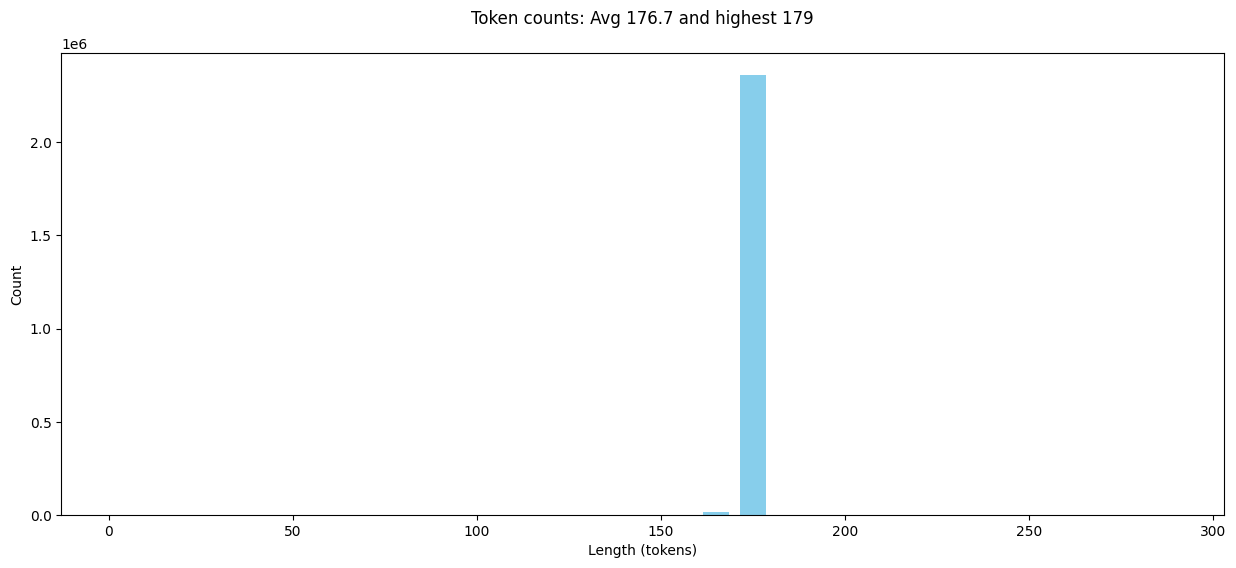

In [12]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

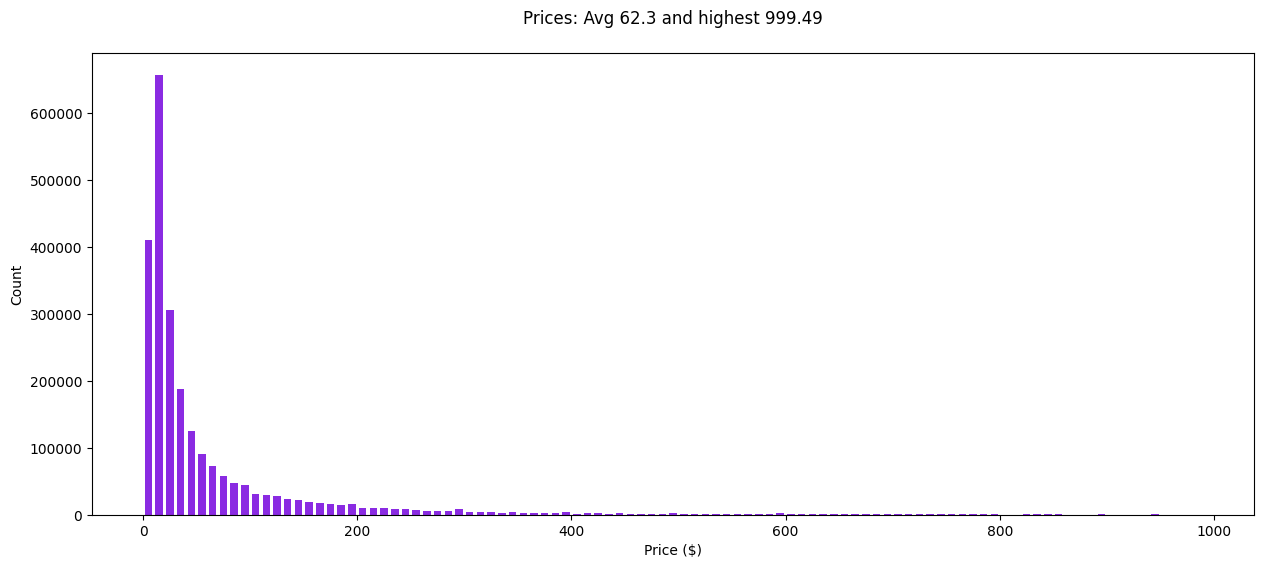

In [13]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

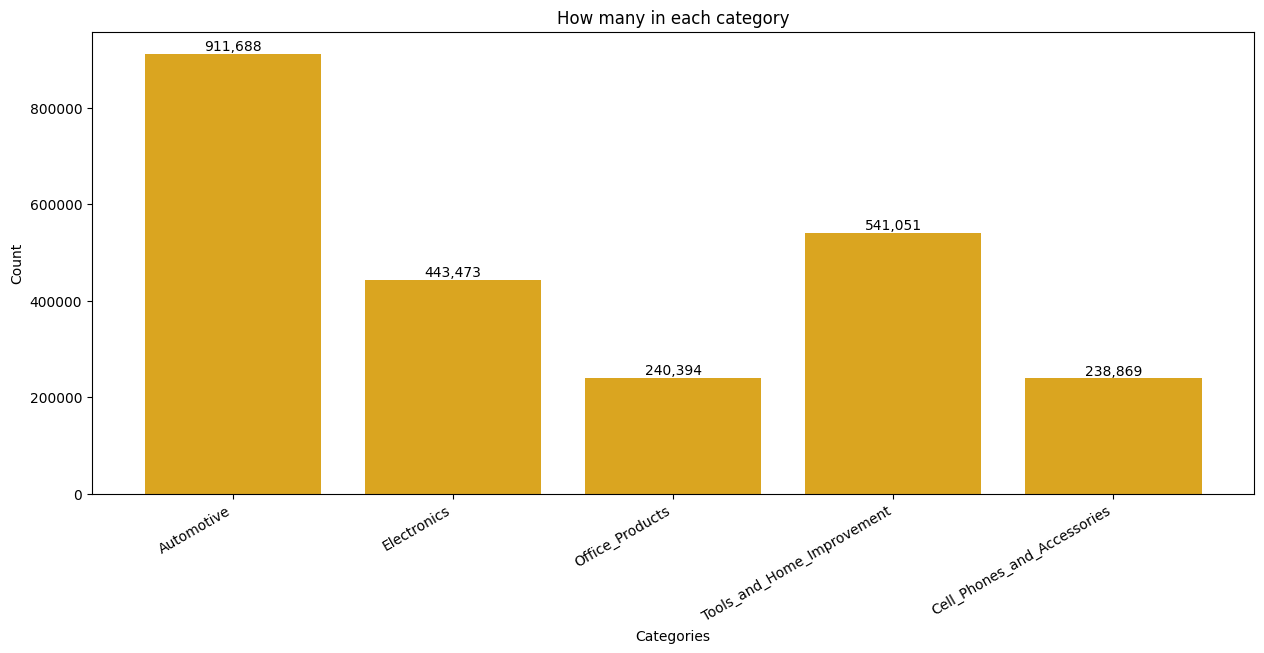

In [14]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [15]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [16]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 391,085 items in the sample


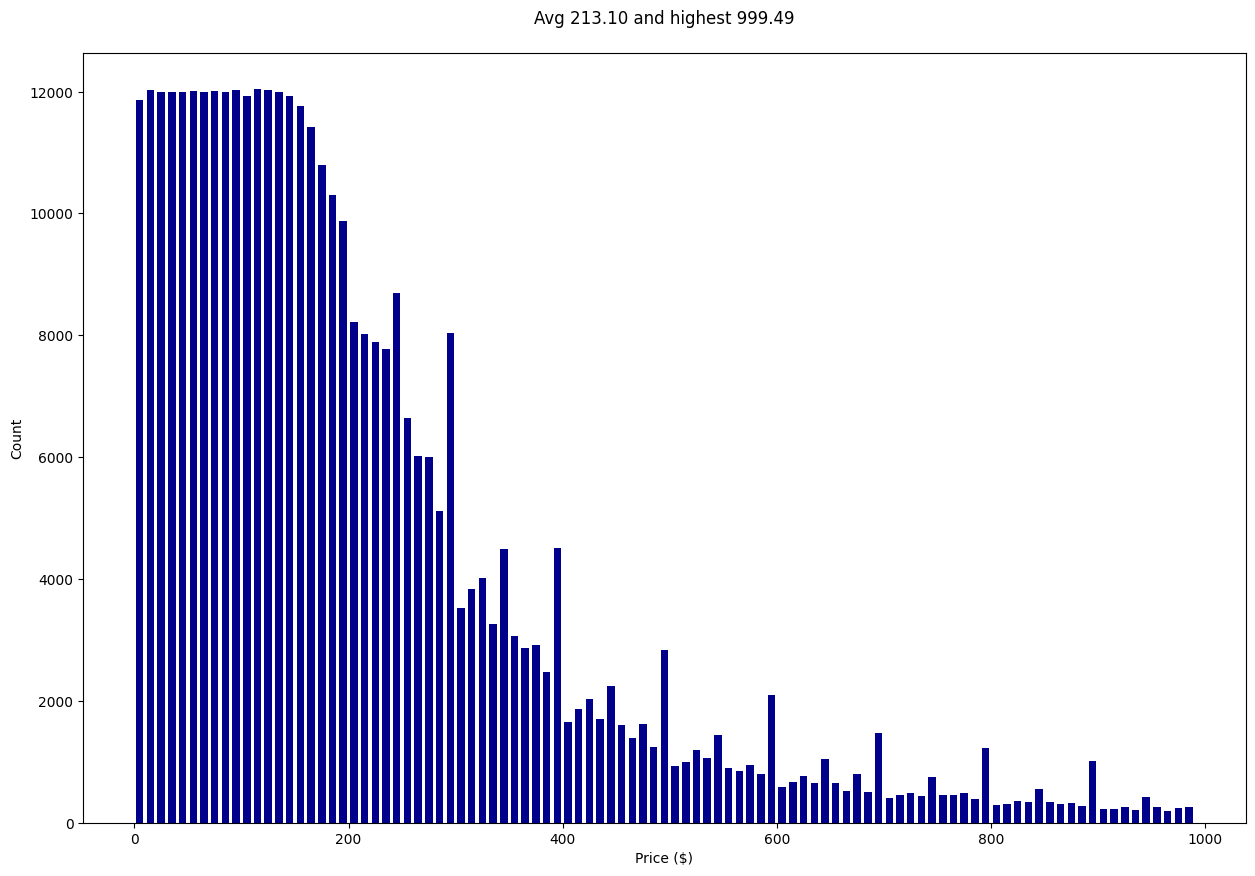

In [17]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

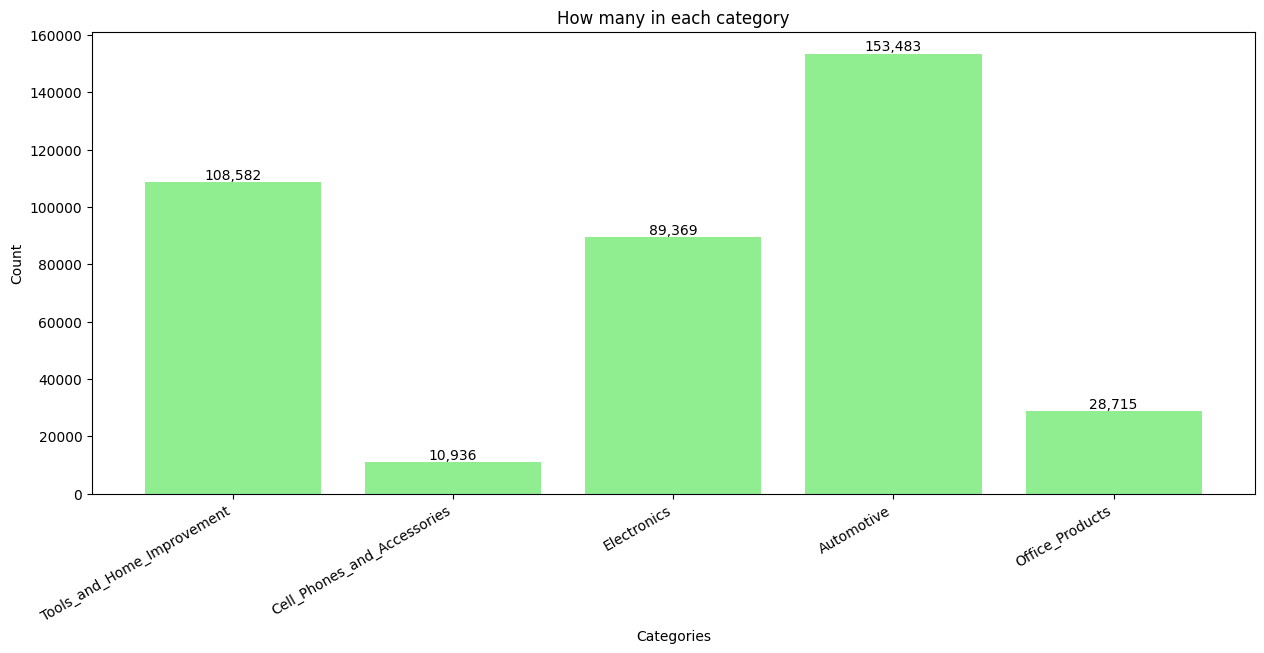

In [18]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

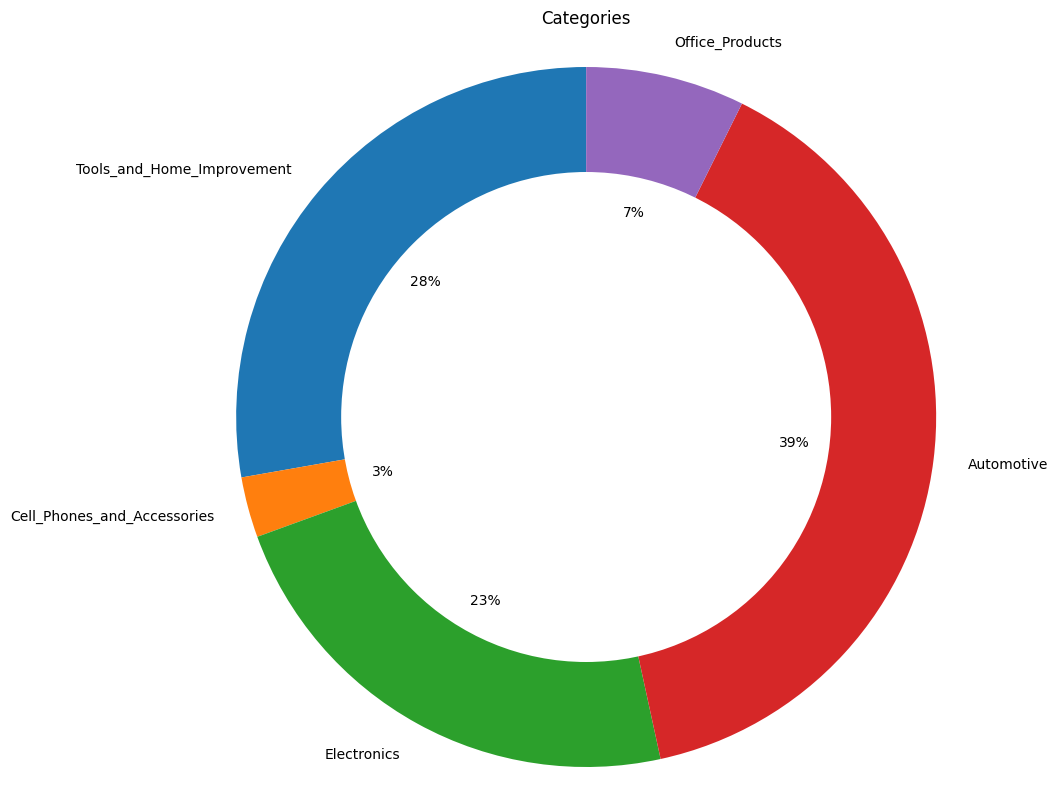

In [19]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

# Dataset Curated!

We've crafted an excellent dataset.

Let's do some final checks

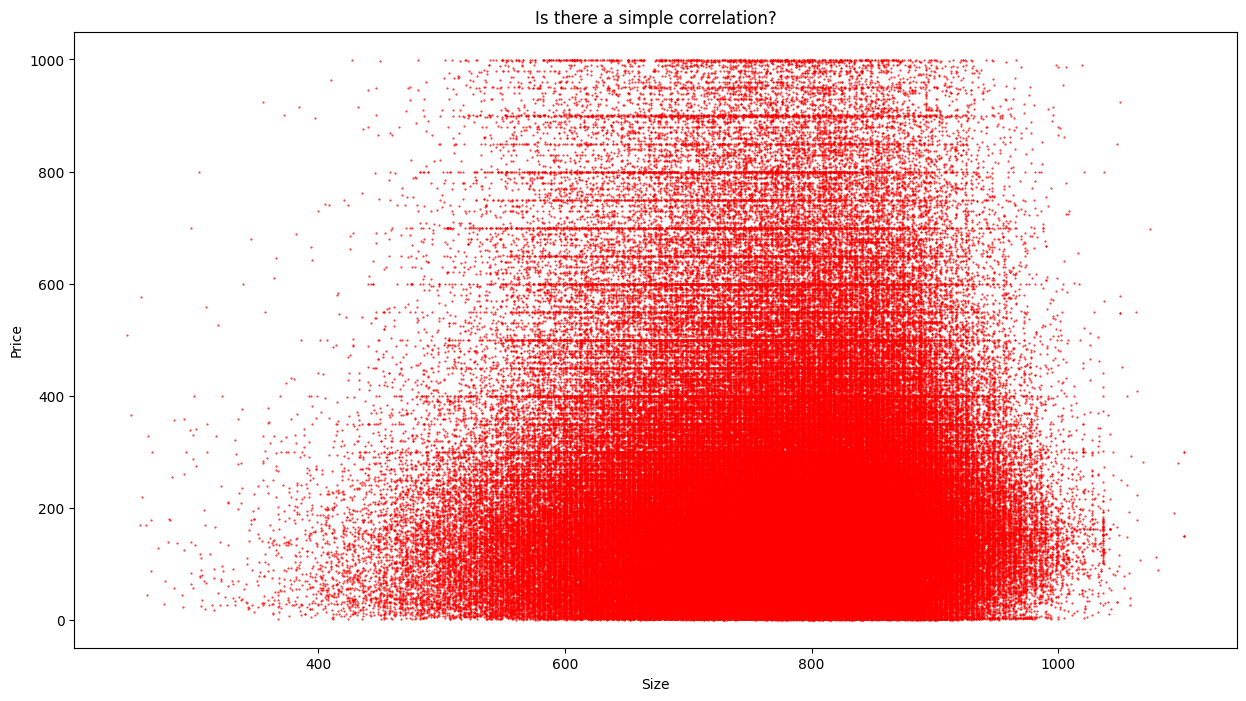

In [20]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [21]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [27]:
len(sample)

391085

In [28]:
report(sample[38911])

How much does this cost to the nearest dollar?

(3 Pack, Super High Yield) TG Imaging Compatible Toner Cartridge Used for M2020W M2022 M2022W M2024W M2070W M2070 Toner Printers (Black)
Package Includes 3 Pack Black Toner Cartridge (1,800 Page Each) Page Yield Toner Cartridge Black 1,800 pages based on 5% coverage per cartridge; High Yield Printer Model Xpress Toner Printer The use of compatible cartridges and supplies does not void your printer’s warranty Please do not hesitate to contact us if you have any questions, our Customer Service Team will respond in 1-2 business days Dimensions 10.9 x 5.5 x 12.1 inches, Weight 4.51 pounds, model number Rank

Price is $33.00
[1646, 1396, 19856, 271, 7117, 374, 400, 1644, 13, 410]
[' model', ' number', ' Rank', '\n\n', 'Price', ' is', ' $', '33', '.', '00']


## Observation

An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

# Finally

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [32]:
random.seed(42)
random.shuffle(sample)
train = sample[:390_000]
test = sample[390_000:391085]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 390,000 items and test set of 1,085 items


In [33]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

iHip On the Go Portable Mini Pocket Speaker for iPod and MP3 Players (Pink )
The iHip On the Go Portable Mini Pocket Speaker for iPod and MP3 players is an excellent option for listeners who want to listen to or share their music without the hassle of wires and ear buds. The On the Go Speaker is the perfect wireless, hands-free way to enjoy your favorite tunes. Fits in your pocket and easy to carrying anywhere Enjoy your iPod music without headsets or large wired external speakers To share your sounds anytime, anywhere Perfect to listening with your music devices or mobile phone No battery required Dimensions 5.25 x 7.75 x 1.25 inches, Weight 0.1 Pounds, Manufacturer Zeikos, model number IP-ONGO-P, Available June 2,

Price is $47.00


In [34]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Ultima Scissor Sharpener - Benchtop Grinder & Polisher with Convexing Clamp for Prossional Quality Scissor & Shear Sharpening
The Ultima Scissors and Shears Sharpener is designed for the professional sharpener. This benchtop sharpener will make sharpening scissors and shears of all sizes and varieties fast, easy, and precise. A free-floating arm with clamp allows you to accurately sharpen scissors and in many cases, make them sharper than when they were brand new! The Ultima Scissors and Shears Sharpener can be set to match all possible angles on any industrial, grooming, and beauty/barber shear up to 14 inches in length. The Ultima 5520 is a benchtop mounted scissor and shear sharpener and polisher designed

Price is $


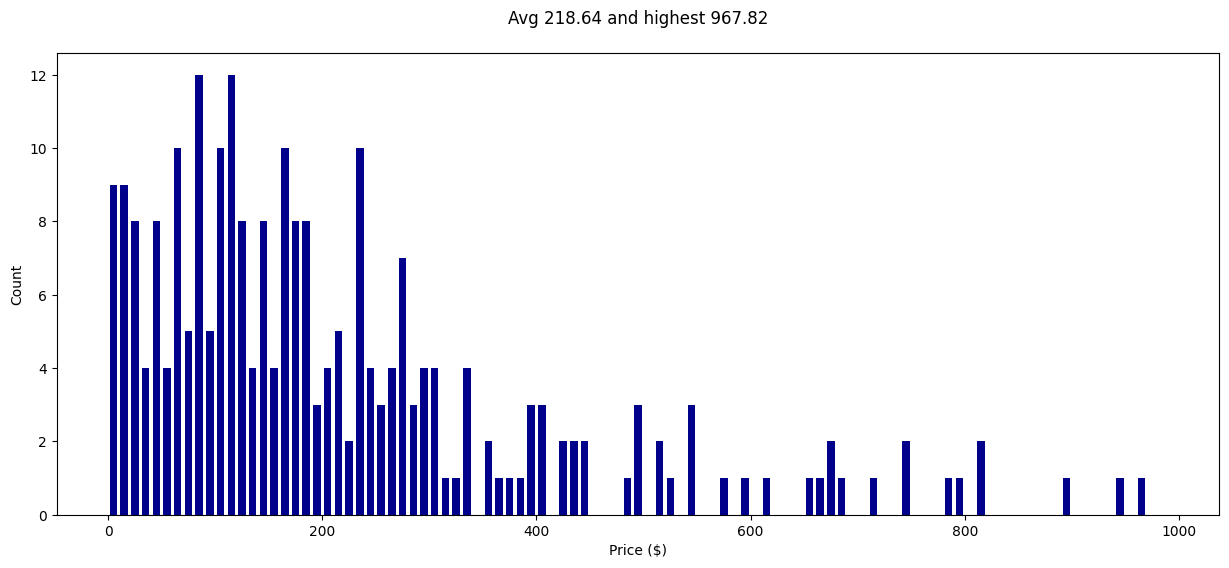

In [35]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [36]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [37]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
# Uncomment these lines if you're ready to push to the hub, and replace my name with your HF username

# HF_USER = "ed-donner"
# DATASET_NAME = f"{HF_USER}/pricer-data"
# dataset.push_to_hub(DATASET_NAME, private=True)

In [40]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

## Todos for you:

- Investigate the dataset more!
- Confirm that the tokenizer tokenizes all 3 digit prices into 1 token